In [12]:
import numpy as np
import json 
import matplotlib.pyplot as plt

# Before Start

Please download (more) samples from [OneDrive](https://1drv.ms/f/c/347c1b40c8c6e5ec/Ej5OQVE_APpOnNuP-ZXpnZcBnr_-ix5W-twQcYIJ-dvW2A?e=YcBSPF), and put them into `data` and `results` folders, respectively.

In [8]:
plan_file_name = '0617-259694+imrt+MOS_33896'
PTVHighname = 'PTV'

data_path = f'data/{plan_file_name}.npz'
data_npz = np.load(data_path, allow_pickle=True)
data_dict = dict(data_npz)['arr_0'].item()

# Metric 1: Mean Absolute Error

### Step 1: Normalize the dose by setting D97 to prescribed dose of PTV_High

We will do this normalization in validation and testing phase, please make sure your predicted dose normalized in the same way. 

In [9]:
scale_dose_Dict = json.load(open('meta_files/PTV_DICT.json'))
ref_dose = data_dict['dose'] * data_dict['dose_scale']
ptv_highdose =  scale_dose_Dict['HNC_001']['PTV_High']['PDose']
norm_scale = ptv_highdose / (np.percentile(ref_dose[data_dict[PTVHighname].astype('bool')], 3) + 1e-5)
ref_dose = ref_dose * norm_scale

### Step 2: Calculate the error

Considering 1) Higher dose region is usually more important in clinical practice and 2) only dose within the body is of the interest, we mask out the regions with the 5 Gy isodose line and body mask. 

In [11]:
#prediction = np.random.random(ref_dose.shape) * 10 # replace random matrix with your prediction

prediction = np.load(f'results/lightning/{plan_file_name}_pred.npy')

isodose_5Gy_mask = ((ref_dose > 5) | (prediction > 5)) & (data_dict['Body'] > 0) # the mask include the body AND the region where the dose/prediction is higher than 5Gy

diff = ref_dose - prediction

error = np.mean(np.abs(diff)[isodose_5Gy_mask > 0])

print (f'the MAE error is {error:.3f}')

the MAE error is 3.566


We show the examples visually that predicted with a very simple basline. Participants can also use the `save_mhd` function in the `toolkit.py` file. 

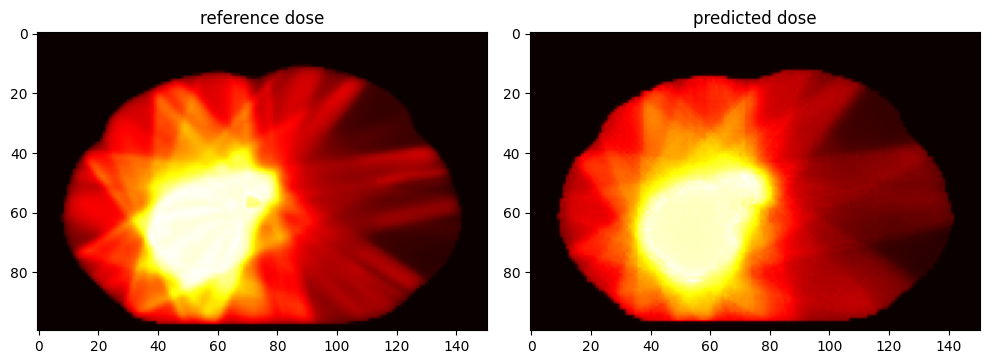

In [14]:
# visually check 

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Plot on the first subplot
ax1.imshow(ref_dose[48], cmap='hot')
ax1.set_title('reference dose')

# Plot on the second subplot
ax2.imshow(prediction[48], cmap='hot')
ax2.set_title('predicted dose')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

# Metric 2: Plan quality of the derived deliverable plan

The plan quality will be evaluted by the organizer using the Eclipse planning system. The participants only need to submit their prediction or solution. The rationale and pipeline of how the deliverable plan being created and how the plan quality metric is calcuated are documented in Ref [1] of <a href="README.md" _target='blank'>README.md</a>. 